In [211]:
# === Loading Packages ===
using Sunny # The main package
using ProgressMeter  #Statistics, Formatting, StaticArrays, LinearAlgebra, DelimitedFiles, OffsetArrays, Random # Some useful peripheral packages
using GLMakie, Plots # Some useful plotting packages
using Statistics, Formatting, StaticArrays, LinearAlgebra, DelimitedFiles, OffsetArrays, JLD2, Random
Sunny.offline_viewers();

In [212]:
a = 1
latvecs = lattice_vectors(a,a,10a,90,90,90)
crystal = Crystal(latvecs, [[0,0,0]])

print_symmetry_table(crystal,1);

Atom 1
Position [0, 0, 0], multiplicity 1
Allowed g-tensor: | A  0  0 |
                  | 0  A  0 |
                  | 0  0  B |
Allowed anisotropy in Stevens operators 𝒪[k,q]:
    c₁*𝒪[2,0] +
    c₂*𝒪[4,0] + c₃*𝒪[4,4] +
    c₄*𝒪[6,0] + c₅*𝒪[6,4]

Bond(1, 1, [1, 0, 0])
Distance 1, coordination 4
Connects [0, 0, 0] to [1, 0, 0]
Allowed exchange matrix: | A  0  0 |
                         | 0  B  0 |
                         | 0  0  C |



In [213]:
L = 2
gtensor=[1.00 0.0 0;0 1 0; 0 0 0.0]
sys = System(crystal, (L,1,1), [SpinInfo(1, S=1/2)], :SUN, units=Units.theory, seed=1)

set_exchange!(sys, [-2.7  0.0 0.0;
                     0.0  0.0 0.0;
                     0.0  0.0 0.0], Bond(1,1,(1,0,0))) #intra dimer J

# set_exchange!(sys,  0.6, Bond(1,1,(0,1,0)))

print_site(crystal, 1)

Atom 1
Position [0, 0, 0], multiplicity 1
Allowed g-tensor: | A  0  0 |
                  | 0  A  0 |
                  | 0  0  B |
Allowed anisotropy in Stevens operators 𝒪[k,q]:
    c₁*𝒪[2,0] +
    c₂*𝒪[4,0] + c₃*𝒪[4,4] +
    c₄*𝒪[6,0] + c₅*𝒪[6,4]


In [214]:
plot_spins(sys,arrowlength=0.2, linewidth=0.05, arrowsize=0.1)
polarize_spins!(sys, (0,-1,0))

In [215]:
# set_anisotropy!(sys, 2*(𝒮[1]^2+𝒮[2]^2), 1)

In [216]:
B=0.00
set_external_field!(sys, (sqrt(B/2),-sqrt(B/2),0))

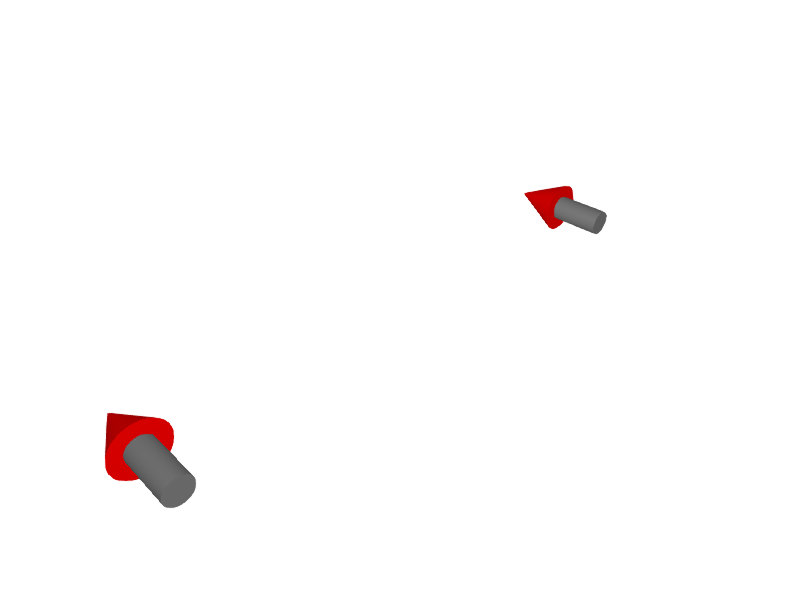

In [217]:
kT=0.025
sampler = LocalSampler(;kT, propose=propose_flip)
nsweeps=50000
x=range(1,stop=nsweeps,step=1)
e=[]
n=[]
for i in 1:nsweeps
    step!(sys, sampler)
    append!(n,i)
#     append!(e, energy(sys))
end
plot_spins(sys,arrowlength=0.2, linewidth=0.05, arrowsize=0.1)

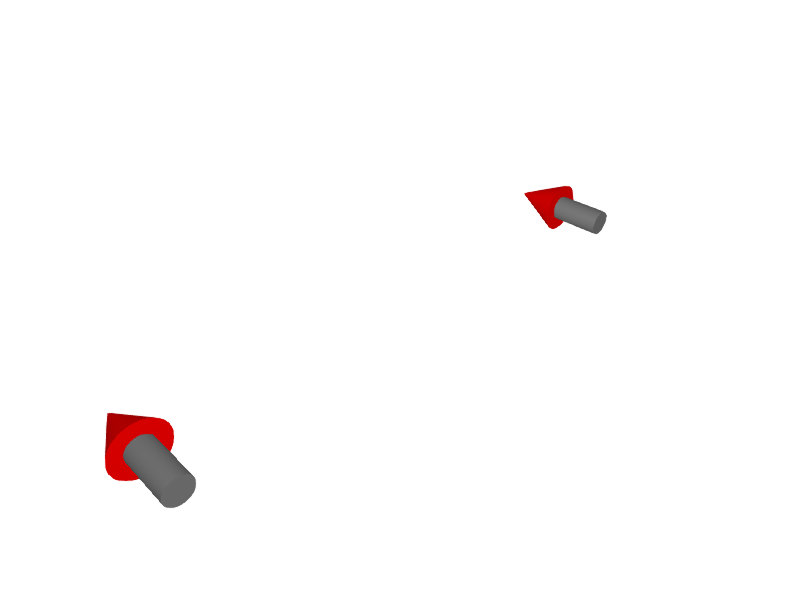

In [218]:
plot_spins(sys,arrowlength=0.2, linewidth=0.05, arrowsize=0.1)

In [219]:
# # Make a `StructureFactor` and calculate an initial sample
sf = DynamicStructureFactor(sys; Δt=0.01, ωmax=3.0, nω=100);

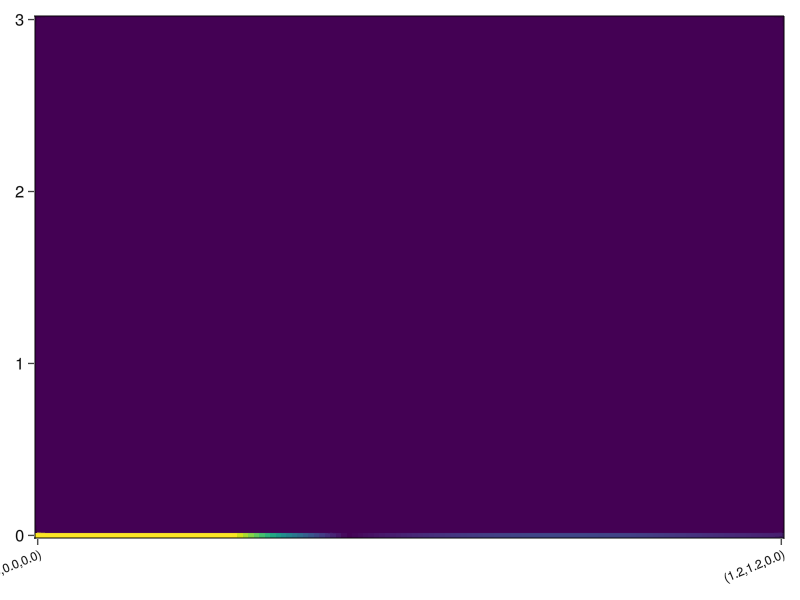

In [220]:
kT=0.025
points = [[0,   0, 0],  # List of wave vectors that define a path
          [1.2,   1.2, 0],]
density = 80
path, markers = connected_path(points, density);

formfactors = [FormFactor(1, "Nd3"; g_lande=0.78)]
is = intensities(sf, path, :perp;
    interpolation = :linear,       # Interpolate between available wave vectors
    kT,                            # Temperature for intensity correction
    formfactors,                   # Form factor information
)
is = broaden_energy(sf, is, (ω, ω₀)->lorentzian(ω-ω₀, 0.00001))  # Add artificial broadening

labels = ["($(p[1]),$(p[2]),$(p[3]))" for p in points]

GLMakie.heatmap(1:size(is,1), ωs(sf), is;
    colorrange=(0, 0.5),
    axis = (
#         ylabel = "meV",
        xticks = (markers, labels),
        xticklabelrotation=π/8,
        xticklabelsize=12,
    )
)